# SMCNOD and Gaussian Mixture Models: 1-D to 2-D
#### Author: Esther Wang

In [66]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from scipy.stats import norm
from collections import OrderedDict
from scipy.stats import gaussian_kde
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import seaborn as sns
import pandas as pd
from astropy import units as u
from schwimmbad import MultiPool

# Overview
- The Bayesian Approach
- 1-D data: radial velocity(rv), metallicity([Fe/H])
- 2-D data: proper motions
- SMCNOD as an example

## The Bayesian Approach: 5 Steps

In astronomy problems, we can use Bayesian analysis to make informed decisions based on observed data. To do this, we follow these steps:

### 1. Make Assumptions: 
We will assume that the observed events are independent and identically distributed. We also assume that the parameters describing the underlying distribution remain constant over time.

### 2. Prior Beliefs: 
Before we analyze the observed data, we must establish our prior beliefs about the parameters describing the distribution. Typically, a combination of normal (Gaussian) distributions is employed; however, in some instances, it may be necessary to use alternative distribution functions informed by astrophysical knowledge.

### 3. Experimental Data:
We will observe some astronomical objects and record their properties. For example, we may measure the kinematics or chemical abundances of a star. 

### 4. Likelihood Function: 
To calculate the probability of the observed data given the parameters of the distribution, we use the likelihood function. This function tells us how likely it is to observe the data we have given a particular set of parameters.

### 5. Posterior Beliefs: 
We can use Bayes' rule to update our prior beliefs and calculate a posterior distribution for the parameters given the observed data. Using a normal distribution as our prior and a specific likelihood function, we obtain a posterior normal distribution.

### 6. Inference: 
With the posterior distribution, we can estimate the parameters of the distribution and make predictions about future observations. We can also compare different models by comparing the posterior distributions obtained using different prior beliefs.

## Exploratory data analysis
#### SMCNOD Data
The data is taken from the S5 Collaboration(Li, T.S.et al., 2019) [Link](https://s5collab.github.io/).

In [89]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
tab = table_cut[high_quality]
# subjective peak selection for member
metalpoor = table_cut['feh50'] < -1.5
sel_peak = (60 <table_cut['vel_calib']) & (table_cut['vel_calib'] < 125.5)
peak_pm = ( 0 < table_cut['pmra'][sel_peak] )  &  ( table_cut['pmra'][sel_peak] < 1.5) & (-1.75 < table_cut['pmdec'] [sel_peak]) & (table_cut['pmdec'] [sel_peak] < -0.6)
smcnod = table_cut[sel_peak][peak_pm]

In [19]:
# check # of stars in data
len(tab)

291

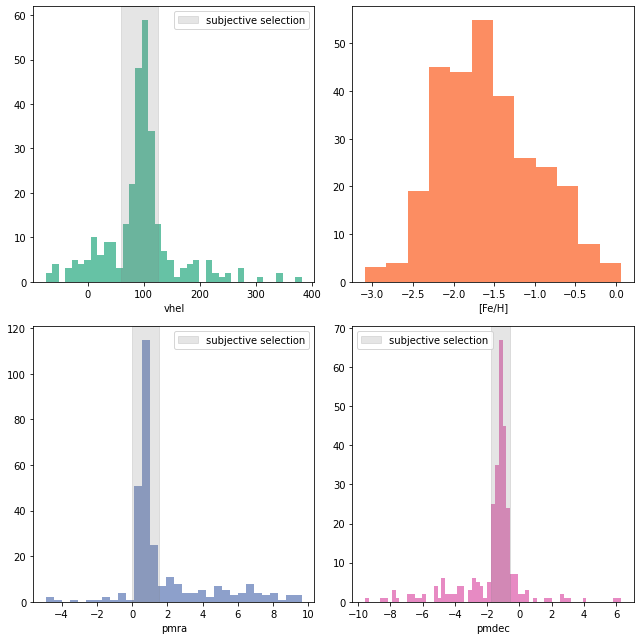

In [83]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
colors = plt.cm.get_cmap('Set2')(np.linspace(0, 1, 8))

axes[0,0].hist(rv, bins='auto', color=colors[0]);
axes[0,0].axvspan(60, 125.5, alpha=0.2, color='grey')
axes[0,0].set_xlabel("vhel")
axes[0,0].legend(["subjective selection"])

axes[0,1].hist(feh, bins='auto', color=colors[1]);
axes[0,1].set_xlabel("[Fe/H]")

axes[1,0].hist(pmra, bins='auto', color=colors[2]);
axes[1,0].axvspan(0, 1.5, alpha=0.2, color='grey')
axes[1,0].set_xlabel("pmra")
axes[1,0].legend(["subjective selection"])

axes[1,1].hist(pmdec, bins='auto', color=colors[3]);
axes[1,1].axvspan(-1.75, -0.6, alpha=0.2, color='grey')
axes[1,1].set_xlabel("pmdec")
axes[1,1].legend(["subjective selection"])

fig.tight_layout()
plt.show()


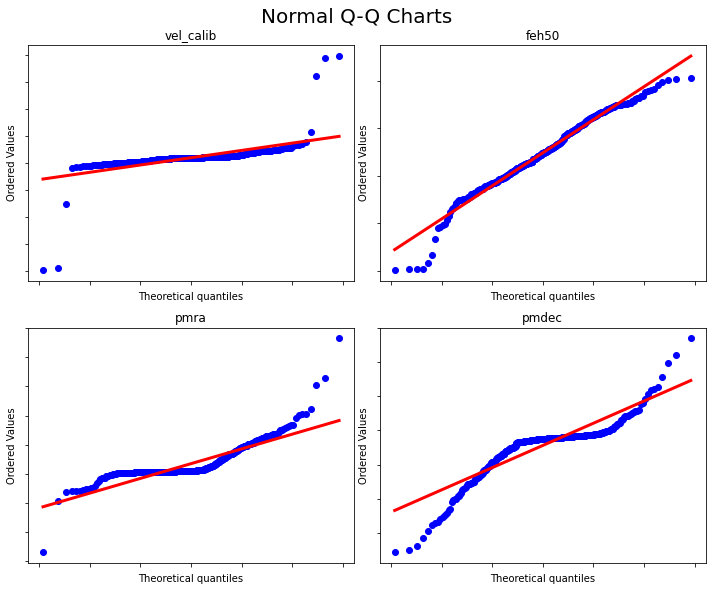

In [170]:
data_feature = table_cut['vel_calib','feh50','pmra','pmdec']
df = data_feature.to_pandas()
figure = plt.figure(figsize = (10,8))
for i in range(len(df.columns)):
    # Q-Q plot
    ax = plt.subplot(2,2, i+1)
    stats.probplot(df.iloc[:,i], dist='norm', plot=plt)
    # Aesthetics
    ax.get_lines()[0].set_markersize(6.0)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(df.columns[i])
figure.tight_layout(h_pad=1.0, w_pad=0.5)
plt.suptitle('Normal Q-Q Charts', y=1.02, fontsize=20)
plt.show()

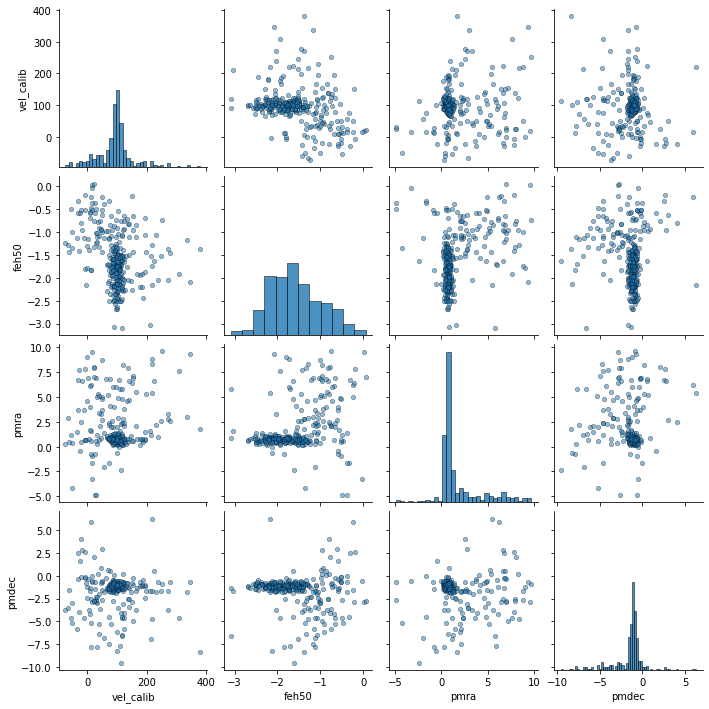

In [40]:
# Convert the Astropy table to a Pandas DataFrame
df = tab.to_pandas()

# Create the pairplot
sns.pairplot(df, vars=["vel_calib", "feh50", "pmra", "pmdec"], diag_kind='hist', 
             plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'k', 'linewidth': 0.5},
             diag_kws={'alpha': 0.8, 'edgecolor': 'k', 'linewidth': 0.5}, palette='Set2')


## Fitting a model to data - 1D
#### Gaussian Mixture Model
We model the candidate stars as a gaussian mixture model containing SMCNOD and 2 BGs.  
#### Total Like-lihood (L): 
$$
\text{log-}\mathcal{L}=f_{\mathrm{SMCNOD}} \text{log-}\mathcal{L}_{\mathrm{SMCNOD}}+f_{\mathrm{bg} 1} \mathcal{Log-}\mathcal{L}_{\mathrm{bg} 1}+f_{\mathrm{bg} 2} \text{log-}\mathcal{L}_{\mathrm{bg} 2}
$$


In [41]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2"]

In [59]:
# Define parameter bounds
bounds = {
    "pgal": (0, 1),
    "pbg1": (0, 1),
    "vhel": (-100, 400),
    "lsigv": (-1, 3),
    "feh": (-10, 10),
    "lsigfeh": (-3, 1),
    "vbg1": (50, 500),
    "lsigvbg1": (-1, 3),
    "fehbg1": (-10, 10),
    "lsigfeh1": (-3, 1),
    "vbg2": (-50, 50),
    "lsigvbg2": (-1, 3),
    "fehbg2": (-10, 10),
    "lsigfeh2": (-3, 1)
}

# Define the log-likelihood function

def log_likelihood(theta):
    # Check if parameters are within bounds
    for i, param in enumerate(theta):
        if not bounds[param_labels[i]][0] <= param <= bounds[param_labels[i]][1]:
            return -np.inf  # return log(0)
    
    # Compute log likelihood in rv
    lgal_vhel = norm.logpdf(rv, loc=theta[2], scale=np.sqrt(rverr**2 + (10**theta[3])**2))
    lbg1_vhel = norm.logpdf(rv, loc=theta[6], scale=np.sqrt(rverr**2 + (10**theta[7])**2))
    lbg2_vhel = norm.logpdf(rv, loc=theta[10], scale=np.sqrt(rverr**2 + (10**theta[11])**2))

    # Compute log likelihood in feh
    lgal_feh = norm.logpdf(feh, loc=theta[4], scale=np.sqrt(feherr**2 + (10**theta[5])**2))
    lbg1_feh = norm.logpdf(feh, loc=theta[8], scale=np.sqrt(feherr**2 + (10**theta[9])**2))
    lbg2_feh = norm.logpdf(feh, loc=theta[12], scale=np.sqrt(feherr**2 + (10**theta[13])**2))

    # Combine the components
    lgal = np.log(theta[0]) + lgal_vhel + lgal_feh
    lbg1 = np.log(theta[1]) + lbg1_vhel + lbg1_feh
    lbg2 = np.log(1 - theta[1]) + lbg2_vhel + lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1 - theta[0]) + lbgtot)    
    return np.sum(ltot)


In [60]:
def get_paramdict(theta):
    return {param_labels[i]: theta[i] for i in range(len(param_labels))}
def project_model(theta, rvmin=-200, rvmax=500, fehmin=-4, fehmax=1):
    """ Turn parameters into rv and feh distributions """
    params = get_paramdict(theta)
    rvarr = np.linspace(rvmin, rvmax, 1000)
    feharr = np.linspace(fehmin, fehmax, 1000)
    
    prv0 = params["pgal"]*stats.norm.pdf(rvarr, loc=params["vhel"], scale=10**params["lsigv"])
    prv1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(rvarr, loc=params["vbg1"], scale=10**params["lsigvbg1"])
    prv2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(rvarr, loc=params["vbg2"], scale=10**params["lsigvbg2"])
    
    pfe0 = params["pgal"]*stats.norm.pdf(feharr, loc=params["feh"], scale=10**params["lsigfeh"])
    pfe1 = (1-params["pgal"])*params["pbg1"]*stats.norm.pdf(feharr, loc=params["fehbg1"], scale=10**params["lsigfeh1"])
    pfe2 = (1-params["pgal"])*(1-params["pbg1"])*stats.norm.pdf(feharr, loc=params["fehbg2"], scale=10**params["lsigfeh2"])
    return rvarr, prv0, prv1, prv2, feharr, pfe0, pfe1, pfe2

def plot_1d_distrs(theta):
    ## I'm being lazy and just using the global variables rv, rverr, feh, feherr.
    ## This makes life hard if you need to debug, but oops
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    model_output = project_model(theta)

    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.hist(rv, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[0:4]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="vhel (km/s)", ylabel="Prob. Density")
    ax.legend(fontsize='small')

    ax = axes[1]
    ax.hist(feh, density=True, color='grey', bins='auto')
    xp, p0, p1, p2 = model_output[4:8]
    ax.plot(xp, p0 + p1 + p2, 'k-', label="Total", lw=3)
    ax.plot(xp, p2, ':', color=colors[2], label="bg2", lw=3)
    ax.plot(xp, p1, ':', color=colors[1], label="bg1", lw=3)
    ax.plot(xp, p0, ':', color=colors[0], label="gal", lw=3)
    ax.set(xlabel="[Fe/H] (dex)", ylabel="Prob. Density")
    ax.legend(fontsize='small')
    return fig
def plot_2d_distr(theta):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(feh, rv, 'k.')
    ax.set(xlabel="[Fe/H] (dex)", ylabel="vhel (km/s)", xlim=(-4,1), ylim=(-100,400))
    
    params = get_paramdict(theta)
    colors = list(plt.rcParams["axes.prop_cycle"].by_key()["color"])
    ax.errorbar(params["feh"], params["vhel"],
               xerr=2*10**params["lsigfeh"], yerr=2*10**params["lsigv"],
               color=colors[0], marker='o', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg1"], params["vbg1"],
               xerr=2*10**params["lsigfeh1"], yerr=2*10**params["lsigvbg1"],
               color=colors[1], marker='x', elinewidth=1, capsize=3, zorder=9999)
    ax.errorbar(params["fehbg2"], params["vbg2"],
               xerr=2*10**params["lsigfeh2"], yerr=2*10**params["lsigvbg2"],
               color=colors[2], marker='.', elinewidth=1, capsize=3, zorder=9999)

    ax.grid()

(0.0, 0.01)

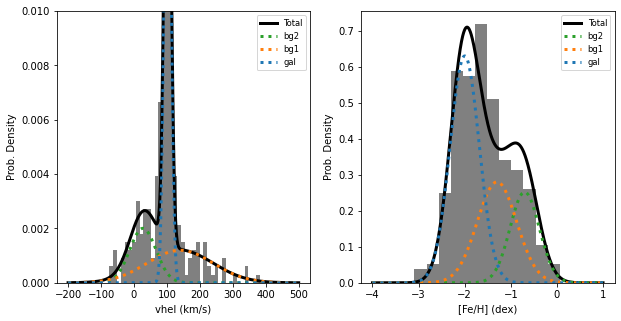

In [61]:
p0_guess = [0.5, 0.6,
            102, 1, -2,-0.5,
            140, 2.0, -1.3, -0.37,
            27, 1.6, -0.7, -0.5]
fig = plot_1d_distrs(p0_guess)
fig.axes[0].set_ylim(0,0.01)

In [62]:
# return the negative log-likelihood (since optimize.minimize minimizes the function
optfunc = lambda theta: -log_likelihood(theta)
# Nelder-Mead method is a gradient-free optimization method that can be slower and less accurate than 
# gradient-based methods for high-dimensional optimization problems.
%time result = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")
print(result.message)

CPU times: user 2.14 s, sys: 11.1 ms, total: 2.15 s
Wall time: 2.14 s
Maximum number of function evaluations has been exceeded.


In [63]:
output = get_paramdict(result.x)
for label, value in output.items():
    print(label, round(value, 2))

pgal 0.55
pbg1 0.35
vhel 98.65
lsigv 1.11
feh -1.86
lsigfeh -0.48
vbg1 179.89
lsigvbg1 1.92
fehbg1 -1.63
lsigfeh1 -0.31
vbg2 40.79
lsigvbg2 1.76
fehbg2 -0.86
lsigfeh2 -0.38


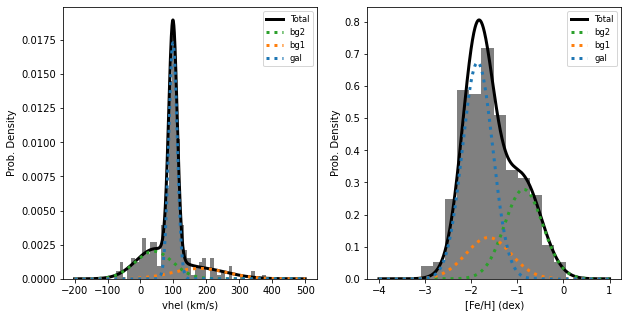

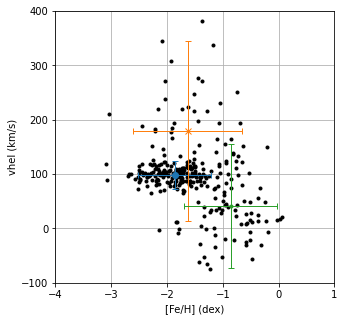

In [64]:
fig1 = plot_1d_distrs(result.x)
fig2 = plot_2d_distr(result.x)

##  Posterior Sampling - MCMC

In [68]:
# number of parameters in the model
nparams = len(param_labels)
# The more walkers there are, the better the sampling, but the longer the calculation will take.
nwalkers = 64
# set the initial guess for the parameters to p0_guess
p0 = result.x
# set the # of burns
nburn = 2000
# sets the initial step size for each parameter to 0.02. 
# This is an arbitrary value that is close to the expected uncertainty in the parameter values. 
# The step size determines how much the walkers move at each step of the MCMC process.
ep0 = np.zeros(len(p0)) + 0.02
# generates a set of initial positions for the walkers by drawing from a multivariate normal distribution 
# with mean p0 and covariance matrix np.diag(ep0)**2
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
# compute the log likelihood of the initial positions for each walker.
lkhds = [log_likelihood(p0s[j]) for j in range(nwalkers)]
# checks that all of the log likelihoods are greater than a very negative number(-9e9 in this case).
# If any of the log likelihoods are less than this number, the model is not well-defined at the initial positions.
assert np.all(np.array(lkhds) > -9e9)

In [69]:
def get_rstate():
    """
    set the initial state of the MCMC process
    """
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
# set up a multiprocessing pool with 8 workers. 
# This allows the MCMC process to run in parallel, which can speed up the calculation.
pool = MultiPool(8)
es = emcee.EnsembleSampler(
    nwalkers, len(p0), log_likelihood)

In [70]:
# runs the MCMC process
%time PP = es.run_mcmc(p0s, nburn, rstate0=get_rstate())
# reset to run the MCMC process again from the same initial positions.
es.reset()

CPU times: user 1min 26s, sys: 261 ms, total: 1min 26s
Wall time: 1min 26s


In [71]:
%time es.run_mcmc(PP.coords, nburn, rstate0=get_rstate())
# np.save("mcmc_result.npy",es.flatchain)

CPU times: user 1min 23s, sys: 187 ms, total: 1min 24s
Wall time: 1min 24s


State([[ 5.25196669e-01  4.01014220e-01  9.76946500e+01  1.11369053e+00
  -1.86714262e+00 -5.52812710e-01  1.70416535e+02  2.02959114e+00
  -1.59265764e+00 -1.83522351e-01  3.89438266e+01  1.76059547e+00
  -8.79532071e-01 -3.84054513e-01]
 [ 5.67924856e-01  3.84109078e-01  9.82089138e+01  1.11492548e+00
  -1.90393282e+00 -5.43172744e-01  1.89829734e+02  1.96423444e+00
  -1.56943491e+00 -2.82035180e-01  4.12759016e+01  1.69507750e+00
  -8.62134679e-01 -3.70475613e-01]
 [ 5.08739520e-01  3.95230183e-01  9.81764946e+01  1.10728064e+00
  -1.83463466e+00 -4.29248786e-01  1.75912566e+02  1.96101756e+00
  -1.58578042e+00 -3.15631852e-01  3.35337395e+01  1.75675119e+00
  -7.90371464e-01 -3.86879230e-01]
 [ 5.33283087e-01  3.88253271e-01  9.89495949e+01  1.05808330e+00
  -1.80701243e+00 -4.39404299e-01  1.87193368e+02  1.91859322e+00
  -1.63633057e+00 -3.63549838e-01  4.92515957e+01  1.77884665e+00
  -9.92886226e-01 -2.96631542e-01]
 [ 5.70599274e-01  5.89329434e-01  9.90911245e+01  1.13177334e

In [72]:
outputs = es.flatchain

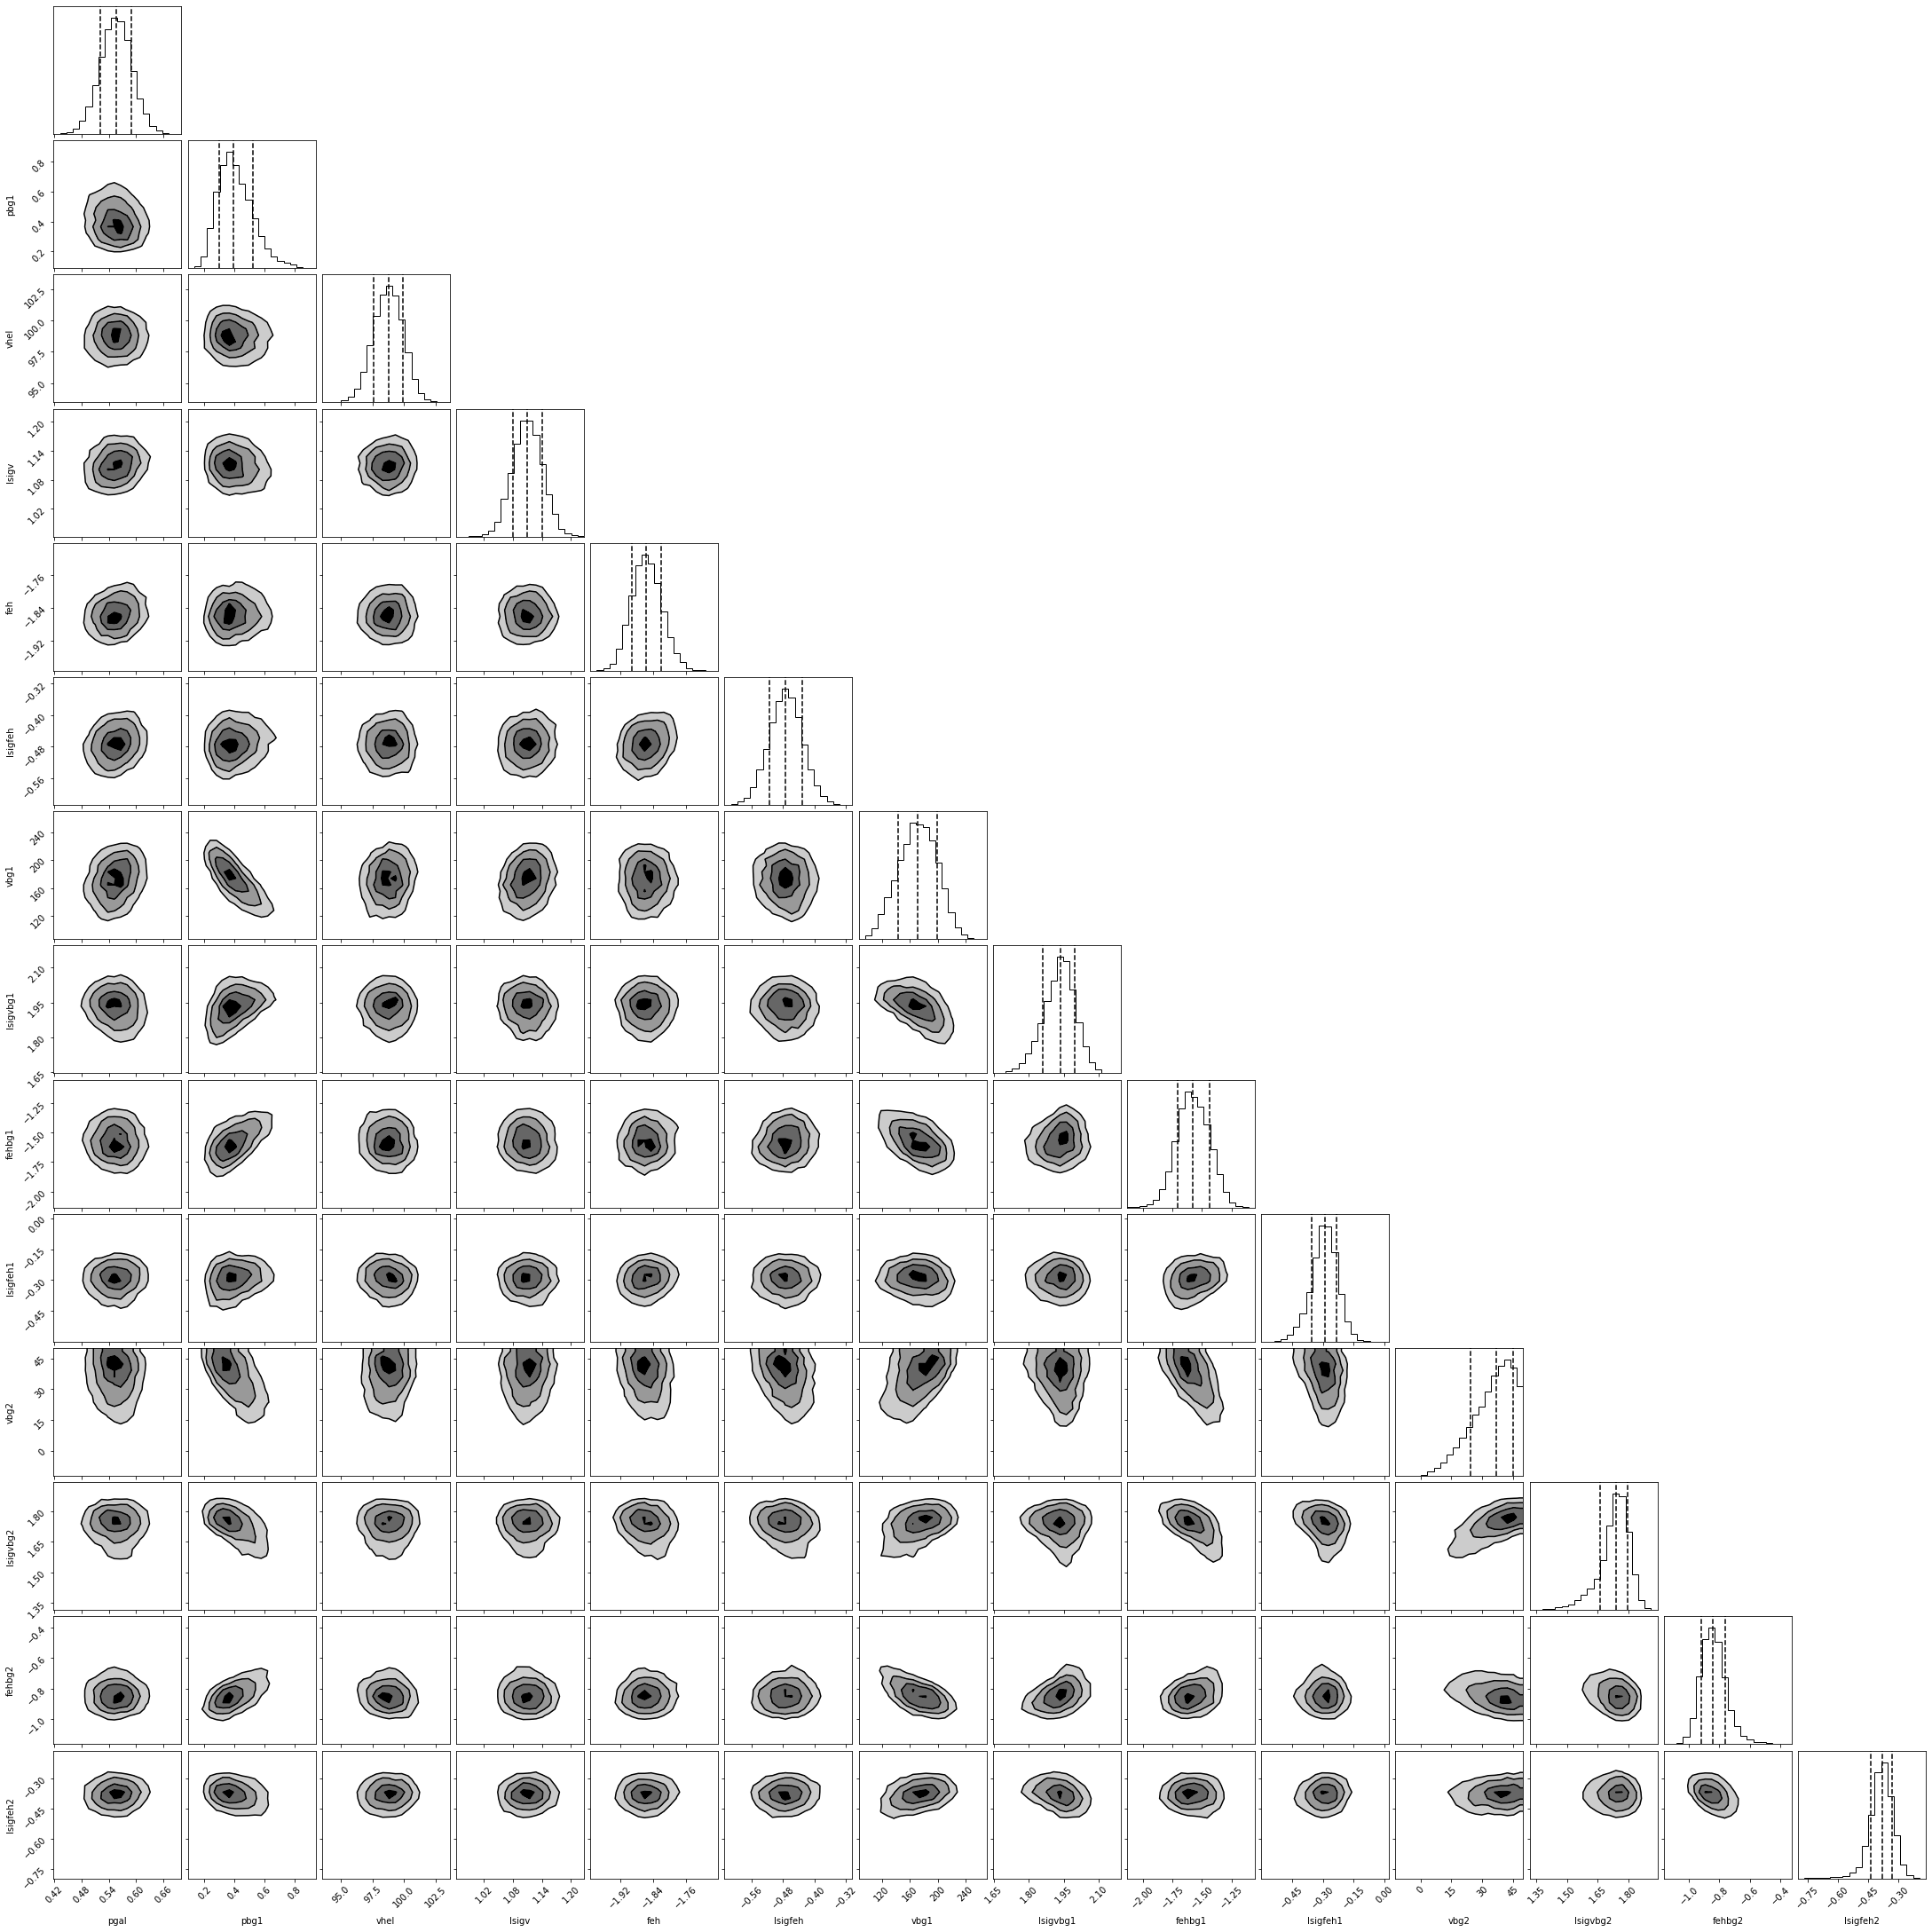

In [73]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [74]:
def process_chain(chain, avg_error=True):
    # Calculate percentiles of the chain
    p16, p50, p84 = np.percentile(chain, [16, 50, 84], axis=0)
    
    # Calculate median and errors
    medians = OrderedDict(zip(param_labels, p50))
    if avg_error:
        errors = OrderedDict(zip(param_labels, (p84 - p16) / 2))
        return medians, errors
    else:
        upper_errors = OrderedDict(zip(param_labels, p84 - p50))
        lower_errors = OrderedDict(zip(param_labels, p50 - p16))
        return medians, upper_errors, lower_errors
    
meds, errs = process_chain(outputs)
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.556 0.034
pbg1 0.394 0.115
vhel 98.759 1.176
lsigv 1.110 0.031
feh -1.857 0.036
lsigfeh -0.473 0.042
vbg1 171.823 28.185
lsigvbg1 1.935 0.068
fehbg1 -1.579 0.137
lsigfeh1 -0.291 0.062
vbg2 36.792 10.561
lsigvbg2 1.740 0.068
fehbg2 -0.844 0.079
lsigfeh2 -0.380 0.053


## Membership Probability
$p=f_{\text {SMCNOD }}\mathcal{L}_{\text {SMCNOD }} /\left(\left(1-f_{\text {SMCNOD }}\right) \mathcal{L}_{\mathrm{MW}}+f_{\text {SMCNOD }} \mathcal{L}_{\text {SMCNOD }}\right)$

In [85]:
pgal=0.556
pbg1=0.394
vhel=98.759
lsigv=1.110
feh=-1.857
lsigfeh=-0.473
vbg1=171.823
lsigvbg1=1.935
fehbg1=-1.579
lsigfeh1=-0.291
vbg2=36.792
lsigvbg2=1.740
fehbg2=-0.844
lsigfeh2=-0.380
theta_opt = pgal, pbg1, vhel, lsigv, feh, lsigfeh, vbg1, lsigvbg1, fehbg1, lsigfeh1, vbg2, lsigvbg2, fehbg2, lsigfeh2

In [86]:
def memprob(theta):
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2 = theta

    #lgal
    ## Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))    
    ## Compute log likelihood in fe
    lgal_feh = stats.norm.logpdf(feh, loc=feh, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2)) 
    ## Combine the components
    lgal = np.log(pgal) + lgal_vhel + lgal_feh
    ## exp of log
    gal = np.exp(lgal)
    
    ## bg1
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))   
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))

    ## Combine the components
    lbg1 = np.log(pbg1) + lbg1_vhel + lbg1_feh
    
    # bg2
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))

    lbg2 = np.log(1-pbg1) + lbg2_vhel + lbg2_feh
    
    # combine bg1 and bg2
    lbgtot = np.logaddexp(lbg1, lbg2)
    bg = np.exp(lbgtot)
    
    # member probability
    p = (gal*pgal)/((gal*pgal)+(1-pgal)*bg)
    return p

In [87]:
# set the threshold to 0.5
tab['memberprob'] = memprob(theta_opt)
tab['membership'] = memprob(theta_opt) > 0.5
tab_good = tab[tab['memberprob'] > 0.5]
tab_bad = tab[tab['memberprob'] <= 0.5]

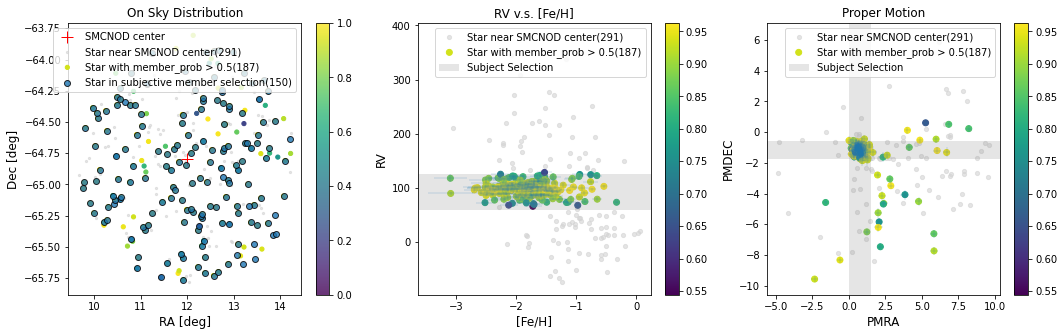

In [129]:
plt.figure(figsize=(24,5))
#plt.suptitle("Scatter Plot of Features", fontsize=20)
plt.subplot(1,4,1)
plt.plot(RA, DEC,'+r',ms=12,label="SMCNOD center")
plt.scatter(tab['ra'],tab['dec'],
            marker='.', s=20, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['ra'],tab_good['dec'], 
            marker='.', s=70, c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(187)')
plt.scatter(smcnod['ra'],smcnod['dec'], 
            marker='o',ec='k', zorder=5, alpha=0.8, label='Star in subjective member selection(150)')
plt.xlabel('RA [deg]', size=12)
plt.ylabel('Dec [deg]', size=12)
plt.title('On Sky Distribution')
plt.legend()
plt.colorbar()
plt.subplot(1,4,2)
plt.scatter(tab['feh50'],tab['vel_calib'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['feh50'], tab_good['vel_calib'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(187)')
plt.errorbar(tab_good['feh50'], tab_good['vel_calib'], xerr=tab_good['feh_std'], yerr=tab_good['vel_calib_std'], 
             fmt='None', marker='None',lw=0.2)
plt.axhspan(60,125.5, facecolor='grey', alpha=0.2, label='Subject Selection')
plt.xlabel('[Fe/H]', size=12)
plt.ylabel('RV', size=12)
#plt.ylim(50,150)
plt.title('RV v.s. [Fe/H]')
plt.legend()
plt.colorbar()
plt.subplot(1,4,3)
plt.scatter(tab['pmra'],tab['pmdec'],
            marker='.', s=70, c='lightgray', zorder=1, alpha=0.6,label='Star near SMCNOD center(291)')
plt.scatter(tab_good['pmra'], tab_good['pmdec'], 
            c=tab_good['memberprob'],cmap='viridis',label='Star with member_prob > 0.5(187)')
plt.errorbar(tab_good['pmra'], tab_good['pmdec'], xerr=tab_good['pmra_error'], yerr=tab_good['pmdec_error'], 
             fmt='None', marker='None',lw=0.2)
plt.axvspan(0, 1.5, facecolor='grey', alpha=0.2)
plt.axhspan(-1.75, -0.6, facecolor='grey', alpha=0.2, label='Subject Selection')
plt.xlabel('PMRA', size=12)
plt.ylabel('PMDEC', size=12)
plt.title('Proper Motion')
#plt.xlim(-0.5,2)
#plt.ylim(-3,0.5)
plt.legend()
plt.colorbar()
plt.show()

## Fitting a model to data - 2D Proper Motions

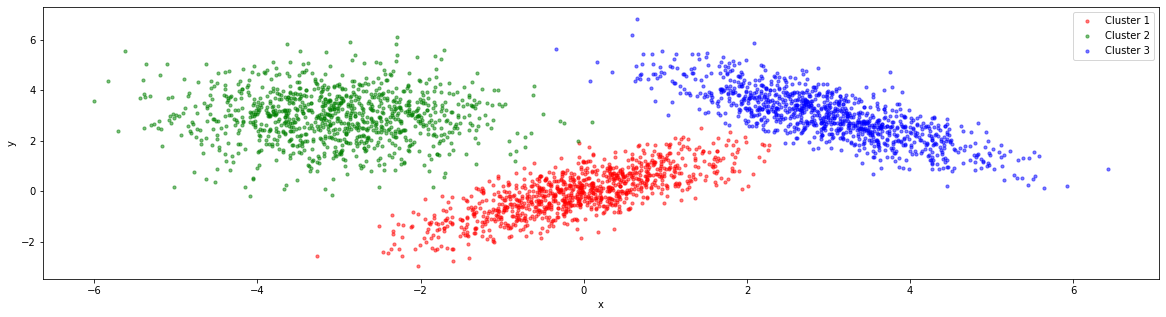

In [122]:
# Generate some mock data
np.random.seed(42)
n_samples = 1000
mean1 = [0, 0]
cov1 = [[1, 0.8], [0.8, 1]]
x1, y1 = np.random.multivariate_normal(mean1, cov1, n_samples).T

mean2 = [3, 3]
cov2 = [[1, -0.8], [-0.8, 1]]
x2, y2 = np.random.multivariate_normal(mean2, cov2, n_samples).T

mean3 = [-3, 3]
cov3 = [[1, 0], [0, 1]]
x3, y3 = np.random.multivariate_normal(mean3, cov3, n_samples).T

x = np.concatenate((x1, x2, x3))
y = np.concatenate((y1, y2, y3))

# Construct covariance matrix
cov = np.cov(x, y)

# Build GMM with 3 components
gmm = GaussianMixture(n_components=3, covariance_type="full")
gmm.fit(np.column_stack((x, y)))

# Plot data
fig, ax = plt.subplots(figsize=(20,5))
colors = ["r", "g", "b"]
labels = ["Cluster 1", "Cluster 2", "Cluster 3"]
for i in range(3):
    ax.scatter(x[gmm.predict(np.column_stack((x, y)))==i], 
               y[gmm.predict(np.column_stack((x, y)))==i], 
               s=10, alpha=0.5, color=colors[i], label=labels[i])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()


### scipy.stats.multivariate_normal
Create a multivariate normal distribution object.

The probability density function (PDF) for the multivariate normal distribution with mean vector $\boldsymbol{\mu}$ and covariance matrix $\mathbf{\Sigma}$ at a point $\mathbf{x}$ is given by:

$$ f(\mathbf{x};\boldsymbol{\mu},\mathbf{\Sigma}) = \frac{1}{\sqrt{(2\pi)^k |\mathbf{\Sigma}|}} \exp\left(-\frac{1}{2} (\mathbf{x}-\boldsymbol{\mu})^\top \mathbf{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu})\right) $$

where $\boldsymbol{\mu}$ is a $k$-dimensional mean vector, $\mathbf{\Sigma}$ is a $k \times k$ covariance matrix, and $\mathbf{x}$ is a $k$-dimensional vector.

### Proper Motions

Measurements of proper motions here are from Gaia eDR3.

**Step 1**: Create a 2-dimensional NumPy array of proper motions with shape (N, 2)

**Step 2**: Calculate the magnitude of the maximum proper motion vector from the pms array and store it in the variable pmmax.

**Step 3**: Normalize the proper motion likelihood function for the entire data set.

**Step 4**: Create covariance matrix values for the proper motion data.

$$ 
C=\left[\begin{array}{cc}
\epsilon_{\mu_\alpha \cos \delta}^2 & \epsilon_{\mu_\alpha \cos \delta \times \mu_\delta}^2 \text{Corr}_{\mu_\alpha \cos \delta \mu_\delta}\\
\epsilon_{\mu_\alpha \cos \delta \times \mu_\delta}^2 \text{Corr}_{\mu_\alpha \cos \delta \mu_\delta} & \epsilon_{\mu_\delta}^2
\end{array}\right]
$$

In [137]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape 
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
# pms array is computed and assigned to the variable pmmax. 
# This is essentially finding the magnitude of the maximum proper motion vector.
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
# normalize the proper motion likelihood function for the entire data set
pmnorm = 1/(np.pi * pmmax**2)
# Covariance Matrix
pmcovs = np.zeros((N,2,2))
pmcovs[:,0,0] = tab["pmra_error"]**2
pmcovs[:,1,1] = tab["pmdec_error"]**2
pmcovs[:,0,1] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
pmcovs[:,1,0] = tab["pmra_error"]*tab["pmdec_error"]*tab["pmra_pmdec_corr"]
#use a dictionary to store data, make the code more organized, easier to read, and more flexible.
pm_data = dict(N=len(tab), pms=pms, pmcovs=pmcovs, pmnorm=pmnorm)

In [144]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2",
                "pmra","pmdec"]
def full_like(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal = theta
    
    pm0s = np.zeros((N,2))
    pm0s[:,0] = pmra_gal
    pm0s[:,1] = pmdec_gal
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50) or (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2):
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    # Compute log likelihood in proper motions
    lgal_pm = [stats.multivariate_normal.logpdf(pms[i], mean=pm0s[i], cov=pmcovs[i]) for i in range(N)]
    lbg1_pm = np.log(pm_data["pmnorm"])
    lbg2_pm = np.log(pm_data["pmnorm"])
    
    # Combine the components
    lgal = np.log(pgal)+lgal_vhel+lgal_pm+lgal_feh
    lbg1 = np.log(pbg1)+lbg1_vhel+lbg1_pm+lbg1_feh
    lbg2 = np.log(1-pbg1)+lbg2_vhel+lbg2_pm +lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal)+lbgtot)
    return ltot.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

In [145]:
p0_guess = [0.47, 0.57,
            102, 1.3, -1.9,-0.5,
            140, 2.0, -1.3, -0.37,
            27, 1.6, -0.7, -0.5,
            0.7, -1.1]

In [146]:
optfunc = lambda theta: -full_like(theta)

In [147]:
%timeit optfunc(p0_guess)
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

19.7 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
CPU times: user 53.7 s, sys: 251 ms, total: 54 s
Wall time: 53.9 s
pgal: 0.520
pbg1: 1.000
vhel: 105.474
lsigv: 1.338
feh: -1.855
lsigfeh: -1.699
vbg1: 77.378
lsigvbg1: 1.993
fehbg1: -1.858
lsigfeh1: -1.302
vbg2: -16.600
lsigvbg2: -1.000
fehbg2: 0.664
lsigfeh2: -0.077
pmra: 0.718
pmdec: -1.153


### MCMC
The next step for running the MCMC to get posterior result is identical to my previous steps for 1-D model.

#### References:
`cda-sampler`: By: Alex Ji [Link](https://github.com/alexji/cda-samplers)

`july21-speagle-stats-notebook`: By: Joshua S. Speagle